In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy




import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

import time

from tqdm import tqdm

In [141]:
plt.style.use('plot_style-Examples_3d.txt')
#plt.style.use('default')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [3]:
from jax.scipy import integrate
def compute_2d_error(pred, u, x, y):
    norm_u = jnp.sqrt(integrate.trapezoid(integrate.trapezoid(u**2, x), y))
    norm_diff = jnp.sqrt(integrate.trapezoid(integrate.trapezoid((pred - u)**2, x), y))
    return norm_diff, norm_diff/norm_u

def compute_1d_error(pred, u, x):
    norm_u = jnp.sqrt(integrate.trapezoid(u**2, x))
    norm_diff = jnp.sqrt(integrate.trapezoid((pred - u)**2, x))
    return norm_diff, norm_diff/norm_u

# Benchmark: stochastic Allen-Cahn with spectral decomposition


We will solve the Allen Cahn equation

\begin{align}
&du = (\nu \Delta u + bu - u^3)dt  + dW_t \\
&u(0, x) = g(x) \\
&u(t,0) = u(t, 1) = 0
\end{align}

This leads to the following disretization:

\begin{align}
&(-h \nu\Delta + (1-bh)I )u_{n+1} = u_n - hu_n^3 + \Delta W_n\\
&u(t,0) = u(t, 1) = 0
\end{align}

Let 
$$
u = \sum_{j=1}^\infty u_j(t)  \sqrt{2}\sin(j\pi x)
$$

\begin{align}
[(-h \nu\Delta + (1-bh)I )u_{n+1}, \psi] = [u_n,\psi] + h[f(u_n), \psi]+ \sqrt{h}[\Delta \xi_n, \psi]
\end{align}

The term 

$$
[f(u_n), \psi]
$$
can be efficiently computed using the DST.



CFL condition: we need 

$$
\lambda_N h = C
$$
where $h$ is the timestep.
But

$$
\lambda_N = \nu\pi^2 N^2
$$

Hence we need 

$$
\nu\pi^2 N^2 h = C
$$

Hence we would like to choose

$$
N^2 h = \frac{1}{\nu\pi^2}
$$

In practice this is difficult to do.

In [126]:
from utils_DST import discrete_sine_transform, vmap_dst, vmap_compute_sine_coef, compute_sine_coefficients

In [158]:
nu = 1e-3
h_spectral  =  2**(-11)
T = h_spectral*2**10*20
print(T)
sigma = 0.01
time_span = jnp.arange(0, T, h_spectral) + h_spectral


n_coef = int(jnp.sqrt(1/h_spectral))*10
n_coef, h_spectral

10.0


(450, 0.00048828125)

In [159]:
# tau = jit(lambda x: x -x**3)
# def spectral_implicit_EM_solver(A, b, h, time_span, y_init, sigma, BM):

#     y = y_init
#     n = y_init.shape[0]

#     #L = scipy.linalg.cho_factor(A + (1-b*h)*jnp.eye(n))
#     A_inv = jnp.diag((h*A + jnp.ones(n))**-1)

#     #noise = []
#     y_history = []
#     print("Number of steps {}".format(time_span.shape[0]))
#     for i,t  in tqdm(enumerate(time_span)):
#         # Sample from the space time white noise
#         xi = BM[:, i]

#         # Evaluate the non linearity in the physical domain
#         non_linear = tau(discrete_sine_transform(y))
#         # Compute the Fourier coefficients
#         non_linear = compute_sine_coefficients(non_linear)

#         # Create the right hand side
#         rhs = y + non_linear*h +sigma*xi
#         y =A_inv@rhs
#         y_history.append(y)


#     return y, jnp.array(y_history)

In [160]:
tau = jit(lambda x: -x**3)
def spectral_implicit_EM_solver(A, b, h, time_span, y_init, sigma, BM):

    y = y_init
    n = y_init.shape[0]

    #L = scipy.linalg.cho_factor(A + (1-b*h)*jnp.eye(n))
    A_inv = jnp.diag((h*A + (1-h)*jnp.ones(n))**-1)

    #noise = []
    y_history = []
    print("Number of steps {}".format(time_span.shape[0]))
    for i,t  in tqdm(enumerate(time_span)):
        # Sample from the space time white noise
        xi = BM[:, i]

        # Evaluate the non linearity in the physical domain
        non_linear = tau(discrete_sine_transform(y))
        # Compute the Fourier coefficients
        non_linear = compute_sine_coefficients(non_linear)

        # Create the right hand side
        rhs = y + non_linear*h +sigma*xi
        y =A_inv@rhs
        y_history.append(y)


    return y, jnp.array(y_history)

In [161]:
key = random.PRNGKey(103)


upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef+1, endpoint=False)[1:] # Do not include 0 or 1!
print(n_coef)

frequencies = jnp.arange(0, n_coef) + 1

# This is the initial condition
coef_g = jnp.zeros(n_coef) #jnp.hstack([random.normal(key, shape= (n_coef,))])/(0.01*frequencies**(2+0.5)*jnp.pi**2  +1)
coef_g = coef_g.at[1].set(1.0)*0.1

g_values = discrete_sine_transform(coef_g)
A= nu*jnp.pi**2*jnp.arange(1, n_coef+1)**2

BM = random.normal(random.PRNGKey(0), (n_coef, time_span.shape[0]-1))*jnp.sqrt(h_spectral)

450


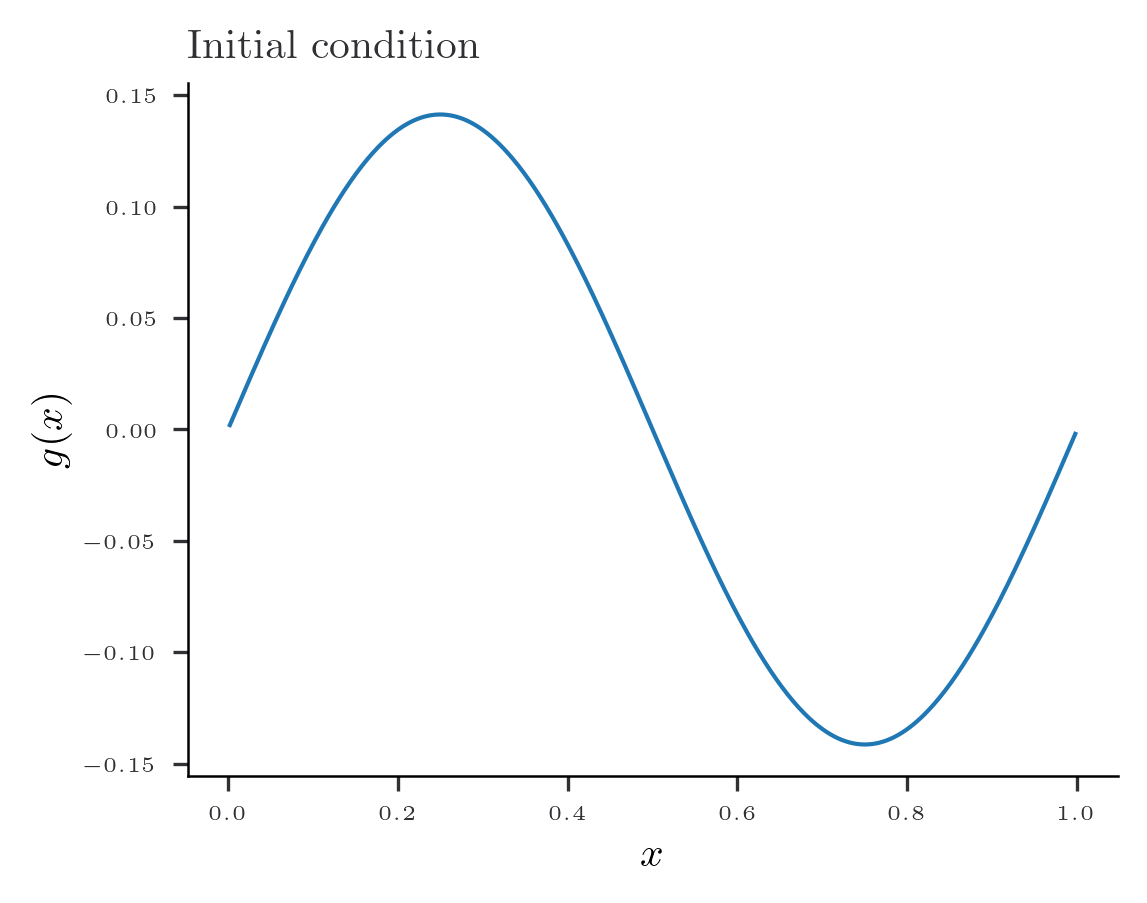

In [162]:
# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, g_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$g(x)$")
plt.title(r"Initial condition")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

In [163]:

start = time.time()
u_final, u_history = spectral_implicit_EM_solver(A, b, h_spectral, time_span, coef_g,  sigma, BM)
end = time.time()
print("Time to integrate the system", jnp.round(end - start, 5))

Number of steps 20480


1854it [00:24, 67.23it/s] 

In [ ]:
u_final_values = discrete_sine_transform(u_final)
u_values_T = vmap_dst(u_history)

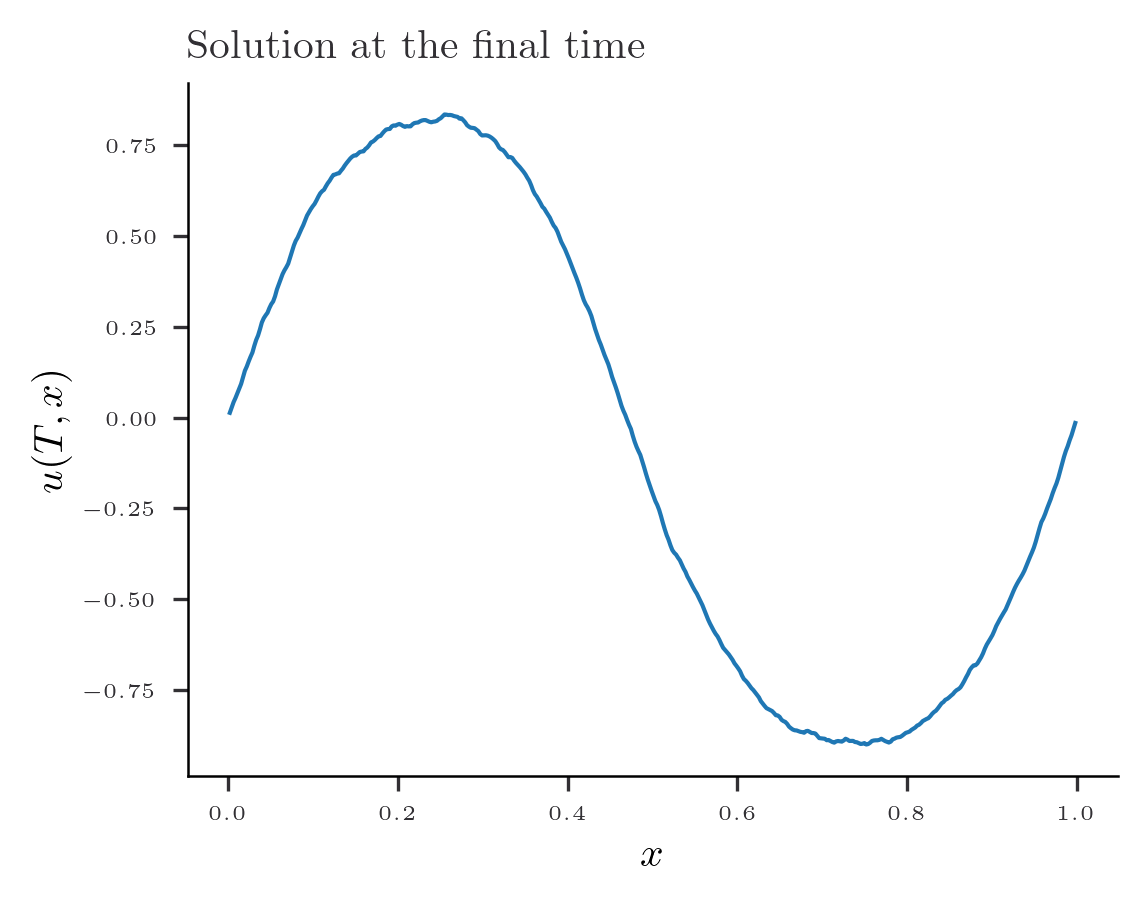

In [ ]:

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, u_final_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$u(T, x)$")
plt.title(r"Solution at the final time")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

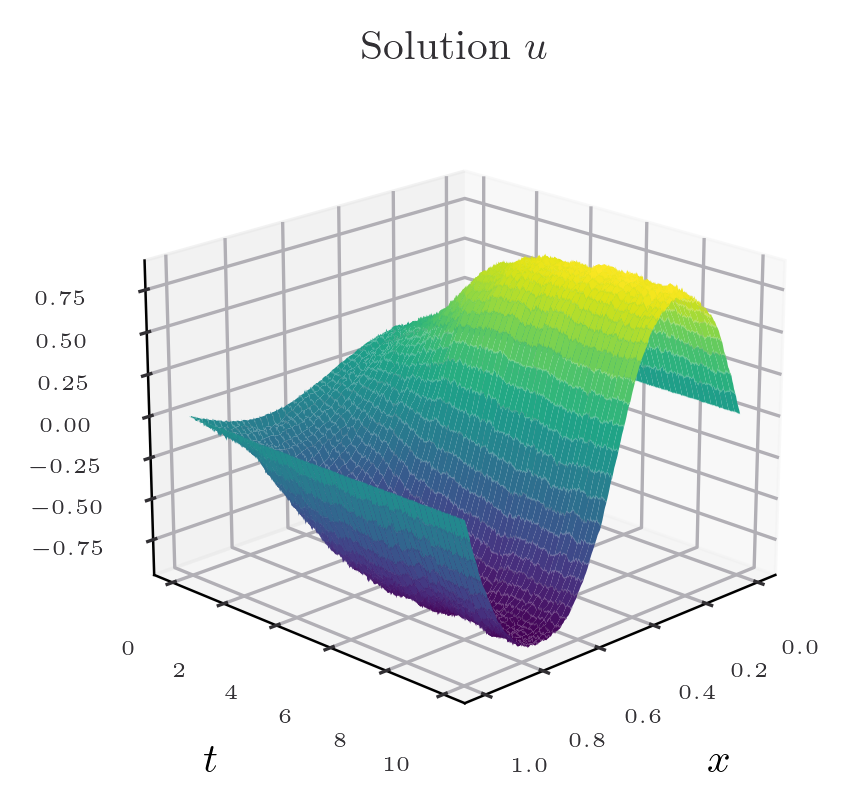

In [ ]:

# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

X, time_grid = jnp.meshgrid(domain_finest, time_span)
# stride = 25
# ax.plot_surface(X, time_grid, u_values_T,  cmap='viridis',  rstride=stride, cstride=stride)


ax.plot_surface(X, time_grid, u_values_T,  cmap='viridis')


#ax.plot_surface(X, time_grid, u_values_T,  cmap='viridis')
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=45)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

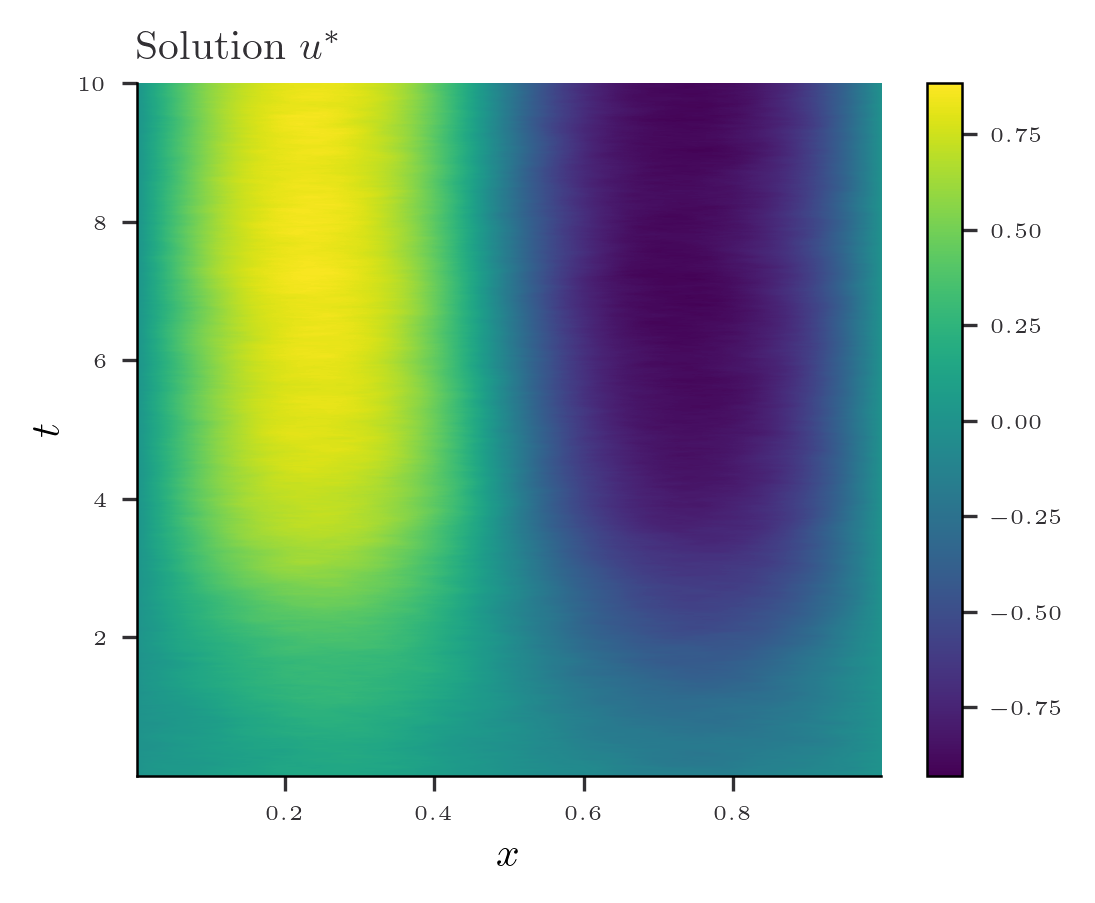

In [ ]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values_T[::-1], cmap='viridis', extent=[domain_finest.min(), domain_finest.max(), time_span.min(), time_span.max()], aspect='auto')
#plt.imshow(u_values_T[::100], cmap='viridis')

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Solving time dependent systems

## Stochastic heat equation

We will solve 

\begin{align}
&du = \Delta u dt  + dW_t \\
&u(0, x) = g(x) \\
&u(t,0) = u(t, 1) = 0
\end{align}

where $\frac{dW_t}{dt}$ is space time white noise. We use an implicit EM method with step size $h$

\begin{align}
&u_0 = g(x) \\
&u_{n+1} = u_n + h \Delta u_{n+1} + \Delta W_n
\end{align}
where 
$$
\Delta W_n \sim \mathcal{N}(0, h I)
$$


Hence 
\begin{align}
&(-h \Delta + I )u_{n+1} = u_n + \Delta W_n\\
&u(t,0) = u(t, 1) = 0
\end{align}

At each step we solve

\begin{align}
[(-h \Delta + I )u_{n+1}, \psi] = [u_n,\psi] + \sqrt{h}[\Delta \xi_n, \psi]
\end{align}



In [593]:
# Generate our Galerkin basis
n_intervals = 2**10
n_meas = n_intervals -1 # We do not include the boundary points
print(n_intervals)
epsilon = (upper- lower)/n_intervals
centers = jnp.linspace(lower, upper, n_intervals + 1)
epsilon = (upper - lower)/n_intervals
epsilon_values  = jnp.ones(n_intervals)*epsilon
intervals = jnp.array([centers[:-1], centers[1:]]).T

1024


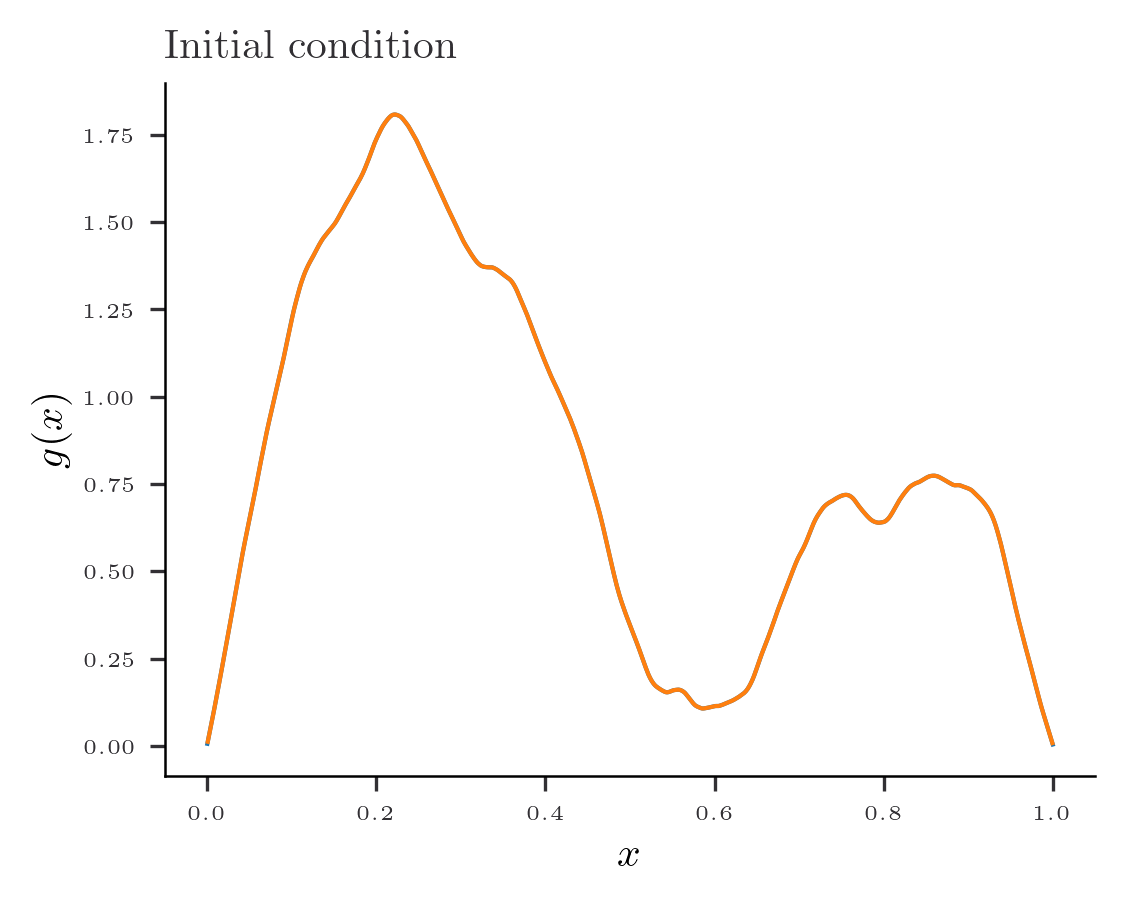

In [594]:
tent_values = vmap_tent(domain_finest, epsilon, centers[1:-1]) # Evaluate the tent functions on the fine grid
tent_proj_coef = vmap_compute_sine_coef(tent_values)  # Project the tent functions onto the sine basis
g_tent = tent_proj_coef@coef_g # We can now project the initial condition onto the tent functions

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, g_values)
plt.plot(centers[1:-1], g_tent)
plt.xlabel(r"$x$")
plt.ylabel(r"$g(x)$")
plt.title(r"Initial condition")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

In [595]:
from utils_rough_pde import vmap_root_interval
from scipy.special import roots_legendre

n_quad = 3
print(n_quad*2-1)
x_q, w_q = roots_legendre(n_quad)
# Quadrature node for the tent element
x_element, w_element = root_interval(x_q, w_q, jnp.array([0, 1]))


# Quadrature node for the kernel
x_quad, w_quad = vmap_root_interval(x_q, w_q, intervals)
k_quad = []
for i in range(n_meas):
    k_quad.append(jnp.hstack([x_quad[i], x_quad[i+1]]))
k_quad = jnp.array(k_quad)

5


In [596]:
# The fundamental element
def tent_element(x, normalization = 1.0):
    
    element = jnp.maximum(0, 1 + (x - 1) )
    

    # Set the element to zero outside the interval
    element = jnp.where(x < 0.0, 0.0, element)
    element = jnp.where(x > 1.0, 0.0, element)

    return element/normalization

element_quad = tent_element(x_element, normalization = 1.0)
tent_quad = jnp.hstack([element_quad, element_quad[::-1]])*jnp.hstack([w_element, w_element[::-1]])

In [597]:
import importlib
import utils_optim
importlib.reload(utils_optim)

from utils_optim import kernel_linear_solver

# length_scale = 1.0
# solver = kernel_linear_solver(length_scale,  tent_quad, k_quad, boundary[:, None], boundary_conditions, 1.0)

In [598]:
h = h_spectral
time_span = jnp.arange(0, T + h, h)
b =lambda x : jnp.ones_like(x)
root_b= b(k_quad)
length_scale = 0.1

In [599]:
linear_solver = kernel_linear_solver(length_scale, tent_quad, k_quad,  boundary[:, None], boundary_conditions, h*nu)


start = time.time()
linear_solver.build_matrices(root_b)
linear_solver.create_K_psi()
linear_solver.create_K_eval(domain_finest)
end = time.time()
print("Time to build the matrices", jnp.round(end - start, 5))

Time to build the matrices 0.22527000000000003


In [600]:
linear_solver.solve(g_tent, None, None, compute_residuals = False)

In [601]:
linear_solver.evaluate_solution_psi()

Array([0.01171965, 0.02342762, 0.03514369, ..., 0.02342348, 0.01562673,
       0.00781396], dtype=float64)

In [602]:
def implicit_EM_solver(time_span, h, linear_solver, y_init,sigma, BM):

    y = y_init

    #noise = []
    c_history = []
    for i,t  in enumerate(time_span):
        # Sample from the space time white noise
        xi = BM[:, i]

        # Create the right hand side
        rhs = y + sigma*xi
        #print(xi[0])

        # Solve the linear system
        linear_solver.solve(rhs, None, None, compute_residuals = False)

        # Update the rhs
        y = linear_solver.evaluate_solution_psi()    

        c_history.append(linear_solver.c)    
        #print(y.shape)

    return y, linear_solver, jnp.array(c_history)

In [603]:
xi_tent = tent_proj_coef@BM*jnp.sqrt(h_spectral)

In [604]:
xi_tent.shape

(1023, 8192)

In [605]:
start = time.time()
y, linear_solver, c_kernel_history= implicit_EM_solver(time_span[1:], h, linear_solver, g_tent, sigma,xi_tent)
end = time.time()
print("Time to integrate the system", jnp.round(end - start, 5))

Time to integrate the system 25.201


In [606]:
pred_kernel = jnp.einsum('ij,kj->ki', linear_solver.K_eval, c_kernel_history)

In [607]:
pred_kernel.shape, time_span.shape

((8192, 2048), (8193,))

In [608]:
compute_2d_error(pred_kernel, u_values_T[1:], domain_finest, time_span[1:])

(Array(0.00349237, dtype=float64), Array(0.00466157, dtype=float64))

In [609]:
error_T, rel_error_T = vmap(compute_1d_error, in_axes=(0, 0, None))(pred_kernel, u_values_T[1:], domain_finest)

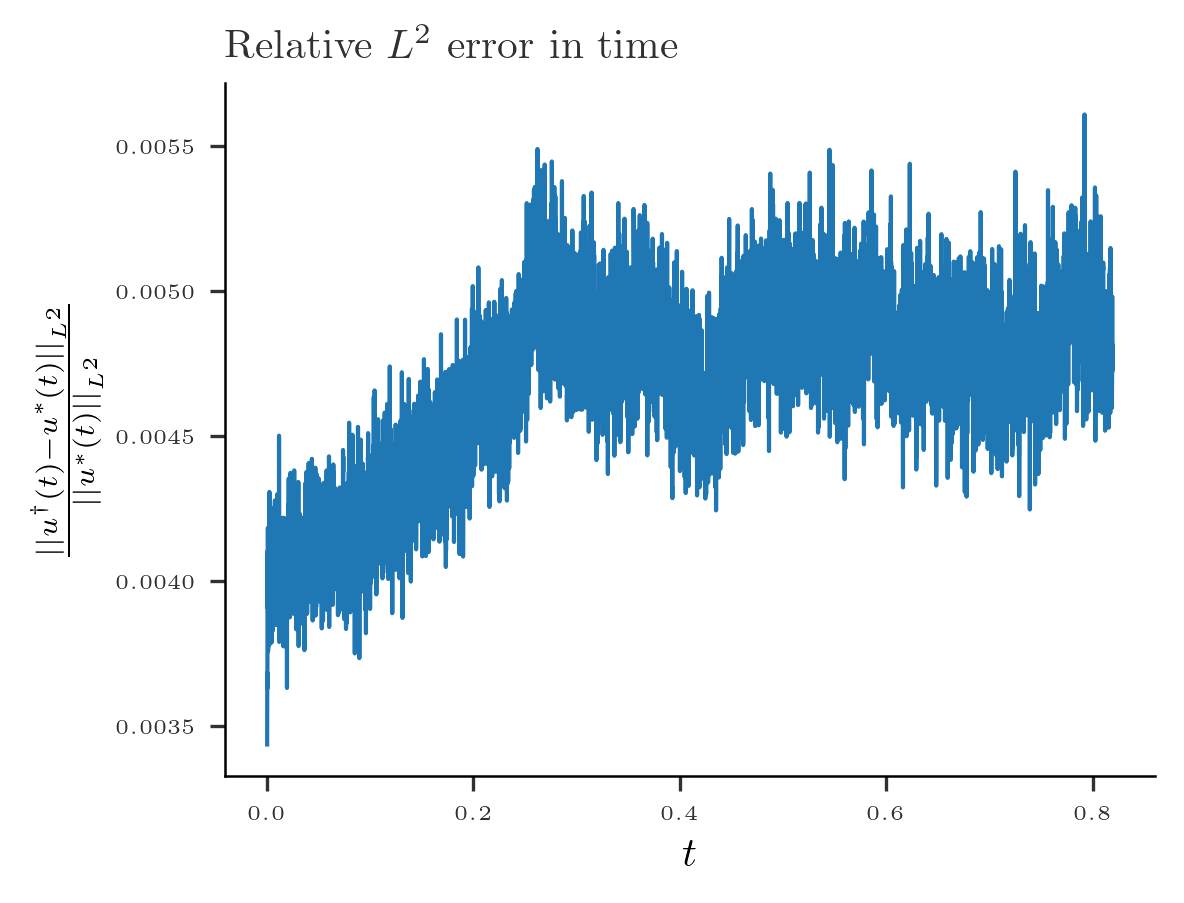

In [610]:
# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(time_span[1:], rel_error_T)
plt.xlabel(r"$t$")
plt.ylabel(r"$\frac{||u^\dagger(t)-u^*(t) ||_{L^2}}{||u^*(t)||_{L^2}}$")
plt.title(r"Relative $L^2$ error in time")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

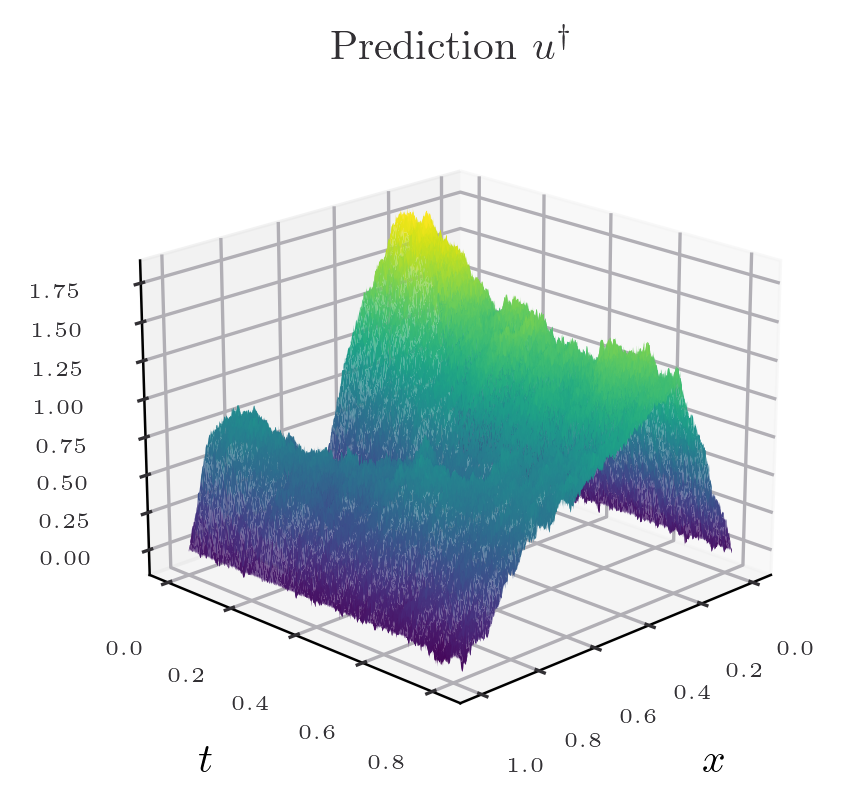

In [611]:

# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

X, time_grid = jnp.meshgrid(domain_finest, time_span[1:])
stride = 25
ax.plot_surface(X, time_grid, pred_kernel,  cmap='viridis',  rstride=stride, cstride=stride)
ax.set_title(r"Prediction $u^\dagger$")
ax.view_init(elev=20, azim=45)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

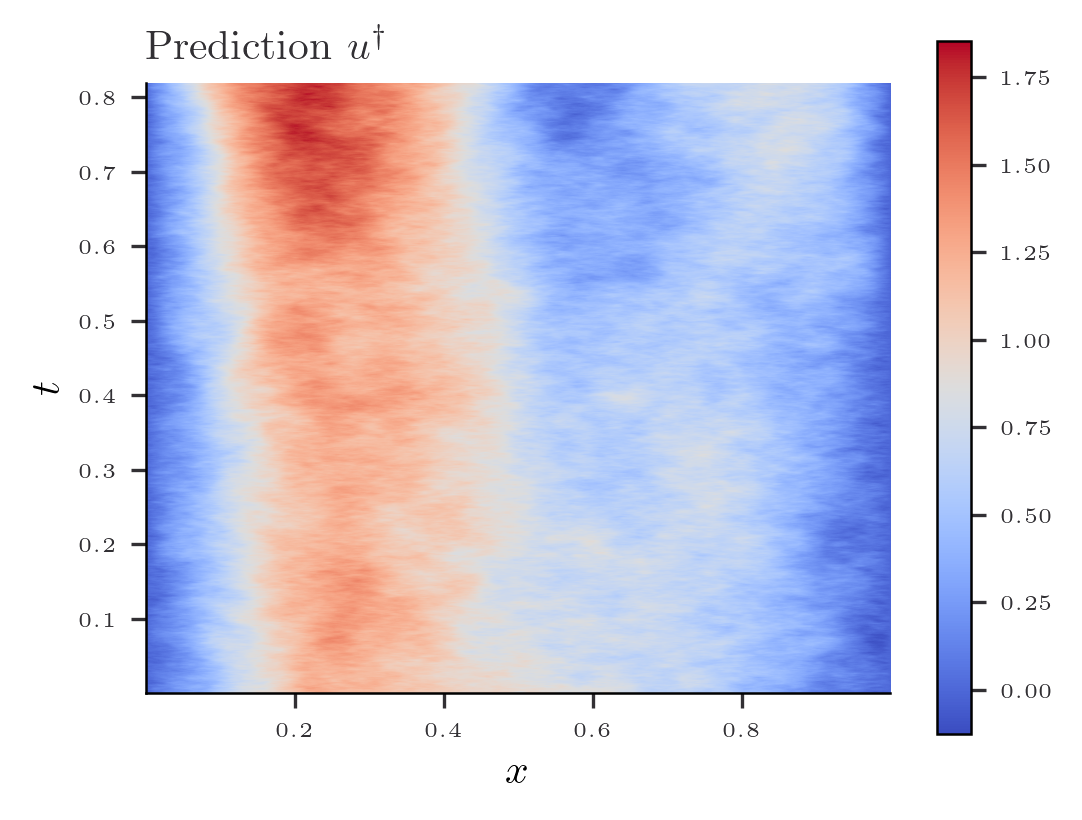

In [612]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_kernel, cmap='viridis', extent=[domain_finest.min(), domain_finest.max(), time_span[1:].min(), time_span[1:].max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Prediction $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

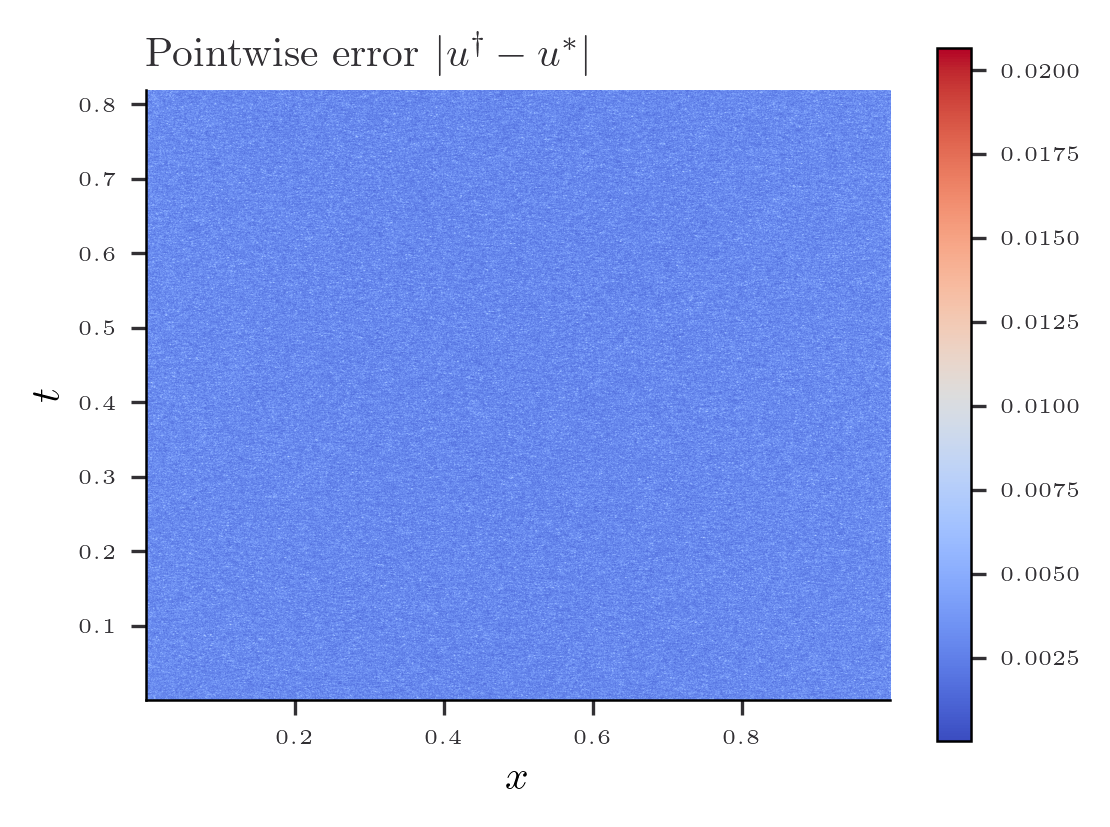

In [613]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_kernel - u_values_T[1:]), cmap='coolwarm', extent=[domain_finest.min(), domain_finest.max(), time_span[1:].min(), time_span[1:].max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Coarser in time

In [724]:
coarse_factor = 4
h = h_spectral*coarse_factor

time_span = jnp.arange(0, T+h, h)
time_span_spectral = jnp.arange(0, T+h_spectral, h_spectral) 
b =lambda x : jnp.ones_like(x)
root_b= b(k_quad)
length_scale = 0.1
cfl_factor = 5

In [725]:
# Generate our Galerkin basis
n_intervals = int(jnp.sqrt(1/h)*cfl_factor) + 1#2**10
n_meas = n_intervals -1 # We do not include the boundary points
print(n_intervals, n_meas, h)
epsilon = (upper- lower)/n_intervals
centers = jnp.linspace(lower, upper, n_intervals + 1)
epsilon = (upper - lower)/n_intervals
epsilon_values  = jnp.ones(n_intervals)*epsilon
intervals = jnp.array([centers[:-1], centers[1:]]).T

251 250 0.0004


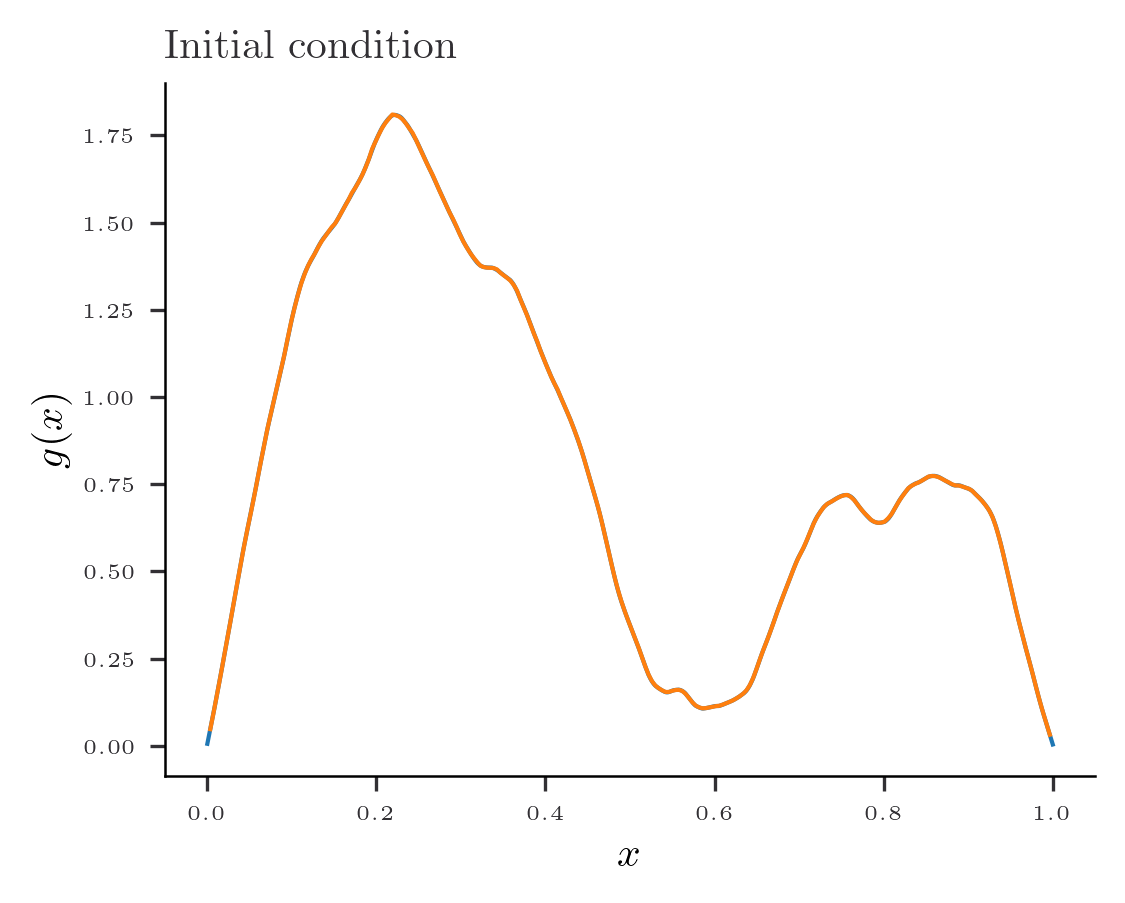

In [726]:
tent_values = vmap_tent(domain_finest, epsilon, centers[1:-1]) # Evaluate the tent functions on the fine grid
tent_proj_coef = vmap_compute_sine_coef(tent_values)  # Project the tent functions onto the sine basis
g_tent = tent_proj_coef@coef_g # We can now project the initial condition onto the tent functions

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, g_values)
plt.plot(centers[1:-1], g_tent)
plt.xlabel(r"$x$")
plt.ylabel(r"$g(x)$")
plt.title(r"Initial condition")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

In [727]:
from utils_rough_pde import vmap_root_interval
from scipy.special import roots_legendre

n_quad = 3
print(n_quad*2-1)
x_q, w_q = roots_legendre(n_quad)
# Quadrature node for the tent element
x_element, w_element = root_interval(x_q, w_q, jnp.array([0, 1]))


# Quadrature node for the kernel
x_quad, w_quad = vmap_root_interval(x_q, w_q, intervals)
k_quad = []
for i in range(n_meas):
    k_quad.append(jnp.hstack([x_quad[i], x_quad[i+1]]))
k_quad = jnp.array(k_quad)

5


In [728]:
# The fundamental element
def tent_element(x, normalization = 1.0):
    
    element = jnp.maximum(0, 1 + (x - 1) )
    

    # Set the element to zero outside the interval
    element = jnp.where(x < 0.0, 0.0, element)
    element = jnp.where(x > 1.0, 0.0, element)

    return element/normalization

element_quad = tent_element(x_element, normalization = 1.0)
tent_quad = jnp.hstack([element_quad, element_quad[::-1]])*jnp.hstack([w_element, w_element[::-1]])

In [729]:
linear_solver = kernel_linear_solver(length_scale, tent_quad, k_quad,  boundary[:, None], boundary_conditions, h*nu)


start = time.time()
linear_solver.build_matrices(root_b)
linear_solver.create_K_psi()
linear_solver.create_K_eval(domain_finest)
end = time.time()
print("Time to build the matrices", jnp.round(end - start, 5))

Time to build the matrices 0.021220000000000003


In [730]:
BM_coarse = BM.reshape(n_coef, time_span_spectral[1:].shape[0] // coarse_factor, coarse_factor)
BM_coarse = jnp.sum(BM_coarse, axis = -1)
xi_tent_coarse = tent_proj_coef@BM_coarse*jnp.sqrt(h_spectral)
#jnp.cumsum(BM[0])[::coarse_factor]

In [731]:
jnp.sum(BM[:, :coarse_factor], axis = -1), jnp.sum(BM[:, coarse_factor:coarse_factor*2], axis = -1)

(Array([-3.02055587,  1.6902322 ,  1.05563782, ...,  0.26086308,
         4.41591379, -1.58096243], dtype=float64),
 Array([-0.19303104,  1.6560458 ,  1.69795681, ..., -2.66875352,
         0.81967753,  1.48228667], dtype=float64))

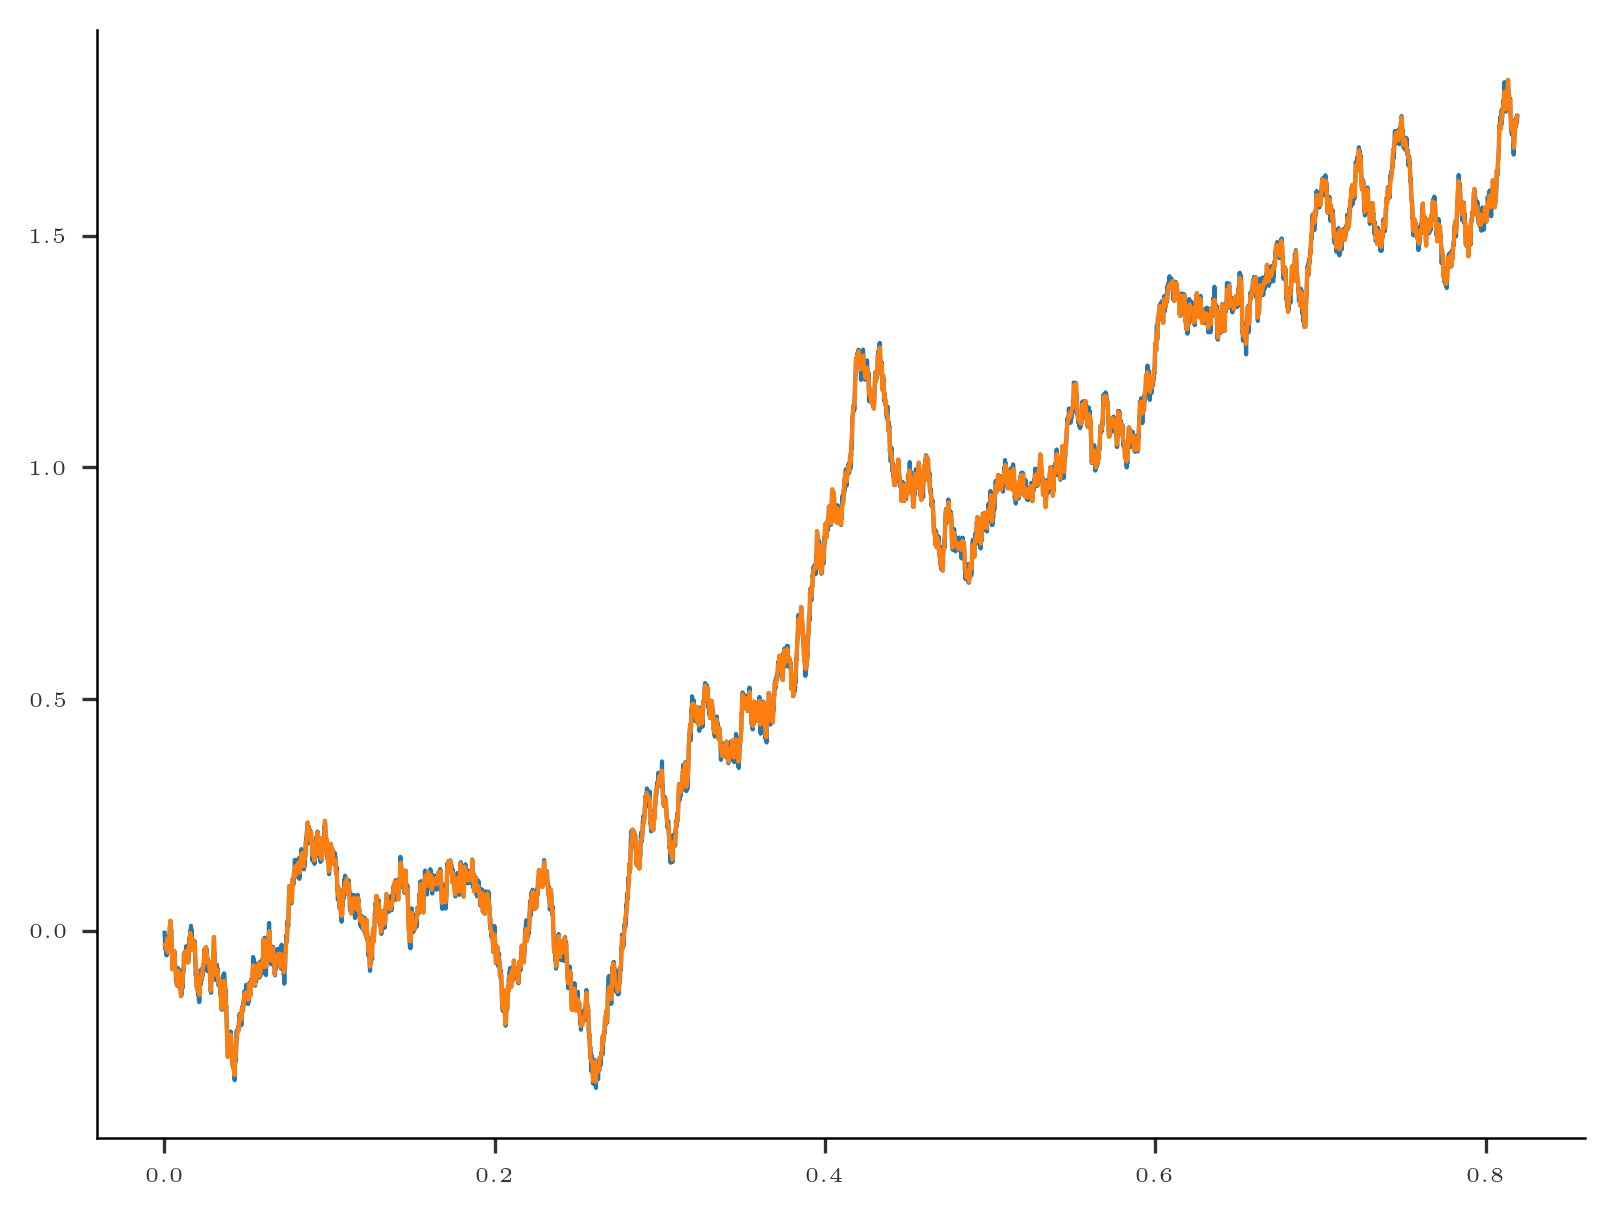

In [732]:
plt.plot(time_span_spectral[1:], jnp.cumsum(BM[0])*jnp.sqrt(h_spectral))
plt.plot(time_span[1:], jnp.cumsum(BM_coarse[0])*jnp.sqrt(h_spectral))

In [733]:
start = time.time()
y, linear_solver, c_kernel_history= implicit_EM_solver(time_span[1:], h, linear_solver, g_tent, sigma,xi_tent_coarse)
end = time.time()
print("Time to integrate the system", jnp.round(end - start, 5))

Time to integrate the system 4.4985100000000005


In [734]:
pred_kernel = jnp.einsum('ij,kj->ki', linear_solver.K_eval, c_kernel_history)

In [735]:
u_coarse = u_values_T[coarse_factor::coarse_factor]
compute_2d_error(pred_kernel, u_coarse, domain_finest, time_span[1:])

(Array(0.00475585, dtype=float64), Array(0.00634955, dtype=float64))

In [736]:
error_T, rel_error_T = vmap(compute_1d_error, in_axes=(0, 0, None))(pred_kernel, u_coarse, domain_finest)

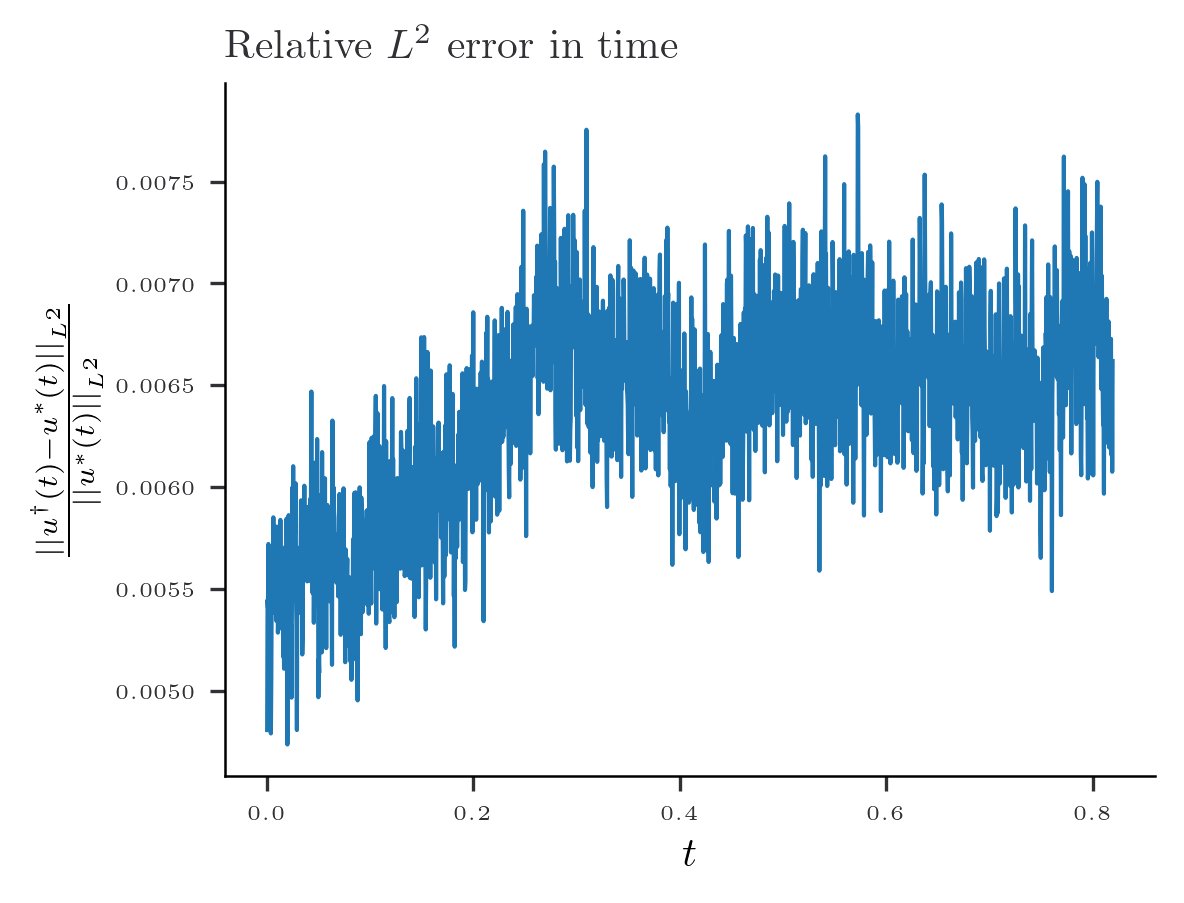

In [737]:
# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(time_span[1:], rel_error_T)
plt.xlabel(r"$t$")
plt.ylabel(r"$\frac{||u^\dagger(t)-u^*(t) ||_{L^2}}{||u^*(t)||_{L^2}}$")
plt.title(r"Relative $L^2$ error in time")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

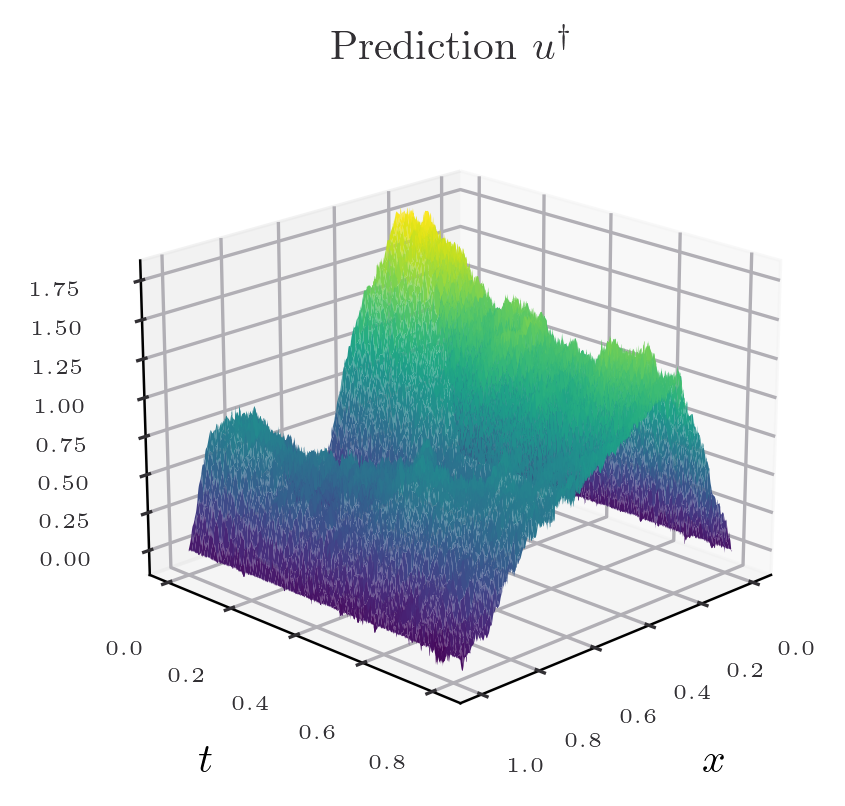

In [738]:

# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

X, time_grid = jnp.meshgrid(domain_finest, time_span[1:])
stride = 25
ax.plot_surface(X, time_grid, pred_kernel,  cmap='viridis',  rstride=stride, cstride=stride)
ax.set_title(r"Prediction $u^\dagger$")
ax.view_init(elev=20, azim=45)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

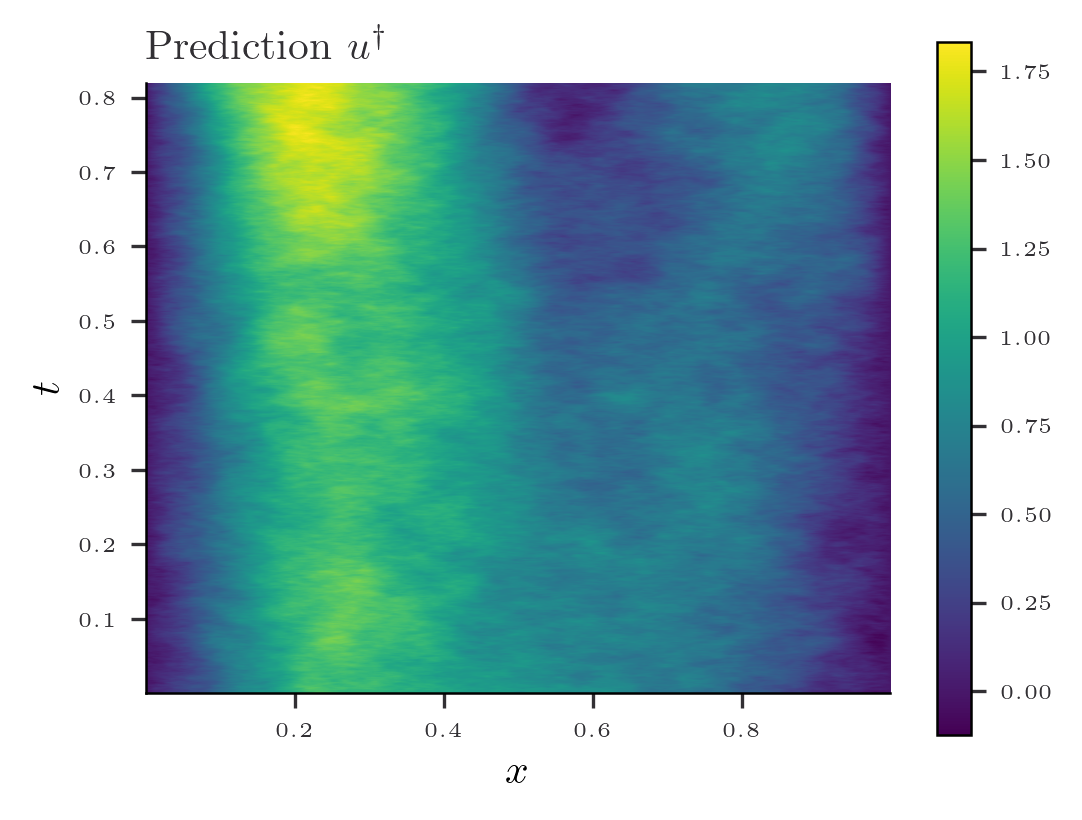

In [739]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_kernel, cmap='viridis', extent=[domain_finest.min(), domain_finest.max(), time_span[1:].min(), time_span[1:].max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Prediction $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

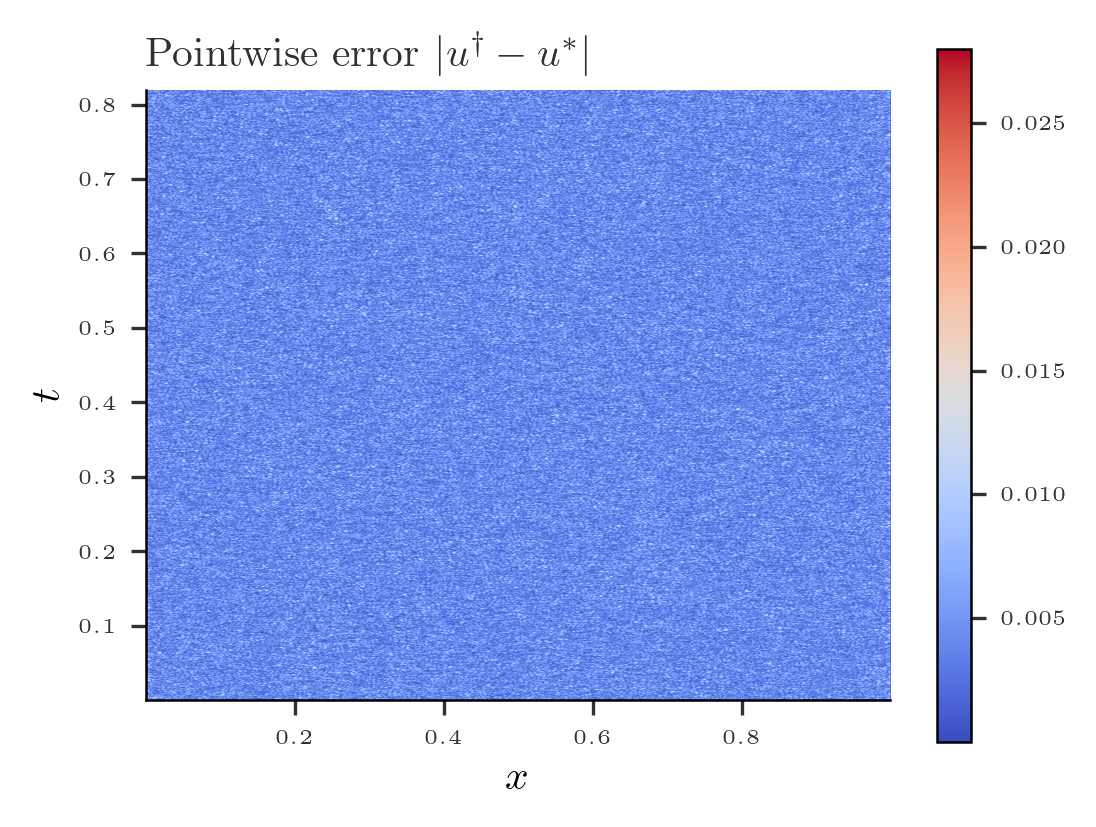

In [709]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_kernel - u_coarse), cmap='coolwarm', extent=[domain_finest.min(), domain_finest.max(), time_span[1:].min(), time_span[1:].max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Computing error rates

In [679]:
h_list = jnp.array([2**i*h_spectral for i in range(2,13)])[::-1]

In [680]:
h_list, jnp.sqrt(1/h_list)*10

(Array([4.096e-01, 2.048e-01, 1.024e-01, 5.120e-02, 2.560e-02, 1.280e-02,
        6.400e-03, 3.200e-03, 1.600e-03, 8.000e-04, 4.000e-04],      dtype=float64),
 Array([ 15.625     ,  22.09708691,  31.25      ,  44.19417382,
         62.5       ,  88.38834765, 125.        , 176.7766953 ,
        250.        , 353.55339059, 500.        ], dtype=float64))

In [683]:
coarse_list = jnp.array([2**i for i in range(13)])[::-1]
coarse_list

Array([4096, 2048, 1024,  512,  256,  128,   64,   32,   16,    8,    4,
          2,    1], dtype=int64)

In [717]:
n_quad = 3
x_q, w_q = roots_legendre(n_quad)

# Quadrature node for the tent element
x_element, w_element = root_interval(x_q, w_q, jnp.array([0, 1]))

cfl_factor = 5

In [718]:
coarse_list = jnp.array([2**i for i in range(2, 10)])[::-1]
error_list = []
error_list_r = []
error_time = []
for coarse_factor in coarse_list:
    h = coarse_factor*h_spectral
    n_meas = int(jnp.sqrt(1/h)*cfl_factor)




    # Generate our Galerkin basis
    n_intervals = n_meas +1
    n_meas = n_intervals -1 # We do not include the boundary points

    epsilon = (upper- lower)/n_intervals
    centers = jnp.linspace(lower, upper, n_intervals + 1)
    epsilon = (upper - lower)/n_intervals
    epsilon_values  = jnp.ones(n_intervals)*epsilon
    intervals = jnp.array([centers[:-1], centers[1:]]).T

    # Quadrature node for the kernel
    x_quad, w_quad = vmap_root_interval(x_q, w_q, intervals)
    k_quad = []
    for i in range(n_meas):
        k_quad.append(jnp.hstack([x_quad[i], x_quad[i+1]]))
    k_quad = jnp.array(k_quad)
    root_b= b(k_quad)

    # Project the initial condition on the Galerkin basis
    tent_values = vmap_tent(domain_finest, epsilon, centers[1:-1]) # Evaluate the tent functions on the fine grid
    tent_proj_coef = vmap_compute_sine_coef(tent_values)  # Project the tent functions onto the sine basis
    g_tent = tent_proj_coef@coef_g # We can now project the initial condition onto the tent functions

    # Coarsen the Wiener process
    BM_coarse = BM.reshape(n_coef, time_span_spectral[1:].shape[0] // coarse_factor, coarse_factor)
    BM_coarse = jnp.sum(BM_coarse, axis = -1)
    xi_tent_coarse = tent_proj_coef@BM_coarse*jnp.sqrt(h_spectral)
    #print(BM_coarse.shape, xi_tent_coarse.shape)



    linear_solver = kernel_linear_solver(length_scale, tent_quad, k_quad,  boundary[:, None], boundary_conditions, h*nu)
    linear_solver.build_matrices(root_b)
    linear_solver.create_K_psi()
    linear_solver.create_K_eval(domain_finest)

    # Integrate
    time_span = jnp.arange(0, T+h, h)
    print(h, n_meas, time_span[1:].shape[0])
    y, linear_solver, c_kernel_history= implicit_EM_solver(time_span[1:], h, linear_solver, g_tent, sigma,xi_tent_coarse)

    pred_kernel = jnp.einsum('ij,kj->ki', linear_solver.K_eval, c_kernel_history)
    u_coarse = u_values_T[coarse_factor::coarse_factor]
    e, e_r = compute_2d_error(pred_kernel, u_coarse, domain_finest, time_span[1:])
    error_list.append(e)
    error_list_r.append(e_r)

    e_t , _  = vmap(compute_1d_error, in_axes=(0, 0, None))(pred_kernel, u_coarse, domain_finest)
    error_time.append(e_t)


0.0512 22 16
0.0256 31 32
0.0128 44 64
0.0064 62 128
0.0032 88 256
0.0016 125 512
0.0008 176 1024
0.0004 250 2048


In [719]:
error = jnp.array(error_list)
error_rel = jnp.array(error_list_r)
max_error_time =jnp.array([jnp.max(e) for e in error_time])
error, error_rel, max_error_time

(Array([0.04137646, 0.02757052, 0.02195251, 0.01724131, 0.01357092,
        0.01016411, 0.0071652 , 0.00475585], dtype=float64),
 Array([0.0577398 , 0.03758624, 0.0295998 , 0.02312337, 0.01815962,
        0.01358298, 0.00956935, 0.00634955], dtype=float64),
 Array([0.05976362, 0.03416463, 0.02831231, 0.02286357, 0.01718613,
        0.01301282, 0.00933786, 0.00611101], dtype=float64))

In [720]:
max_error_time

Array([0.05976362, 0.03416463, 0.02831231, 0.02286357, 0.01718613,
       0.01301282, 0.00933786, 0.00611101], dtype=float64)

In [721]:
meas_list = []
for coarse_factor in coarse_list:
        h = coarse_factor*h_spectral
        n_meas = jnp.sqrt(1/h)*cfl_factor
        meas_list.append(T/h*n_meas)
meas_list = jnp.array(meas_list)
meas_list

Array([3.53553391e+02, 1.00000000e+03, 2.82842712e+03, 8.00000000e+03,
       2.26274170e+04, 6.40000000e+04, 1.81019336e+05, 5.12000000e+05],      dtype=float64)

In [722]:
# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(meas_list)
log_error = jnp.log(error)

a = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
b_2 = log_error
r, C = jnp.linalg.lstsq(a, b_2)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 

L^2 Convergence rate:  0.28


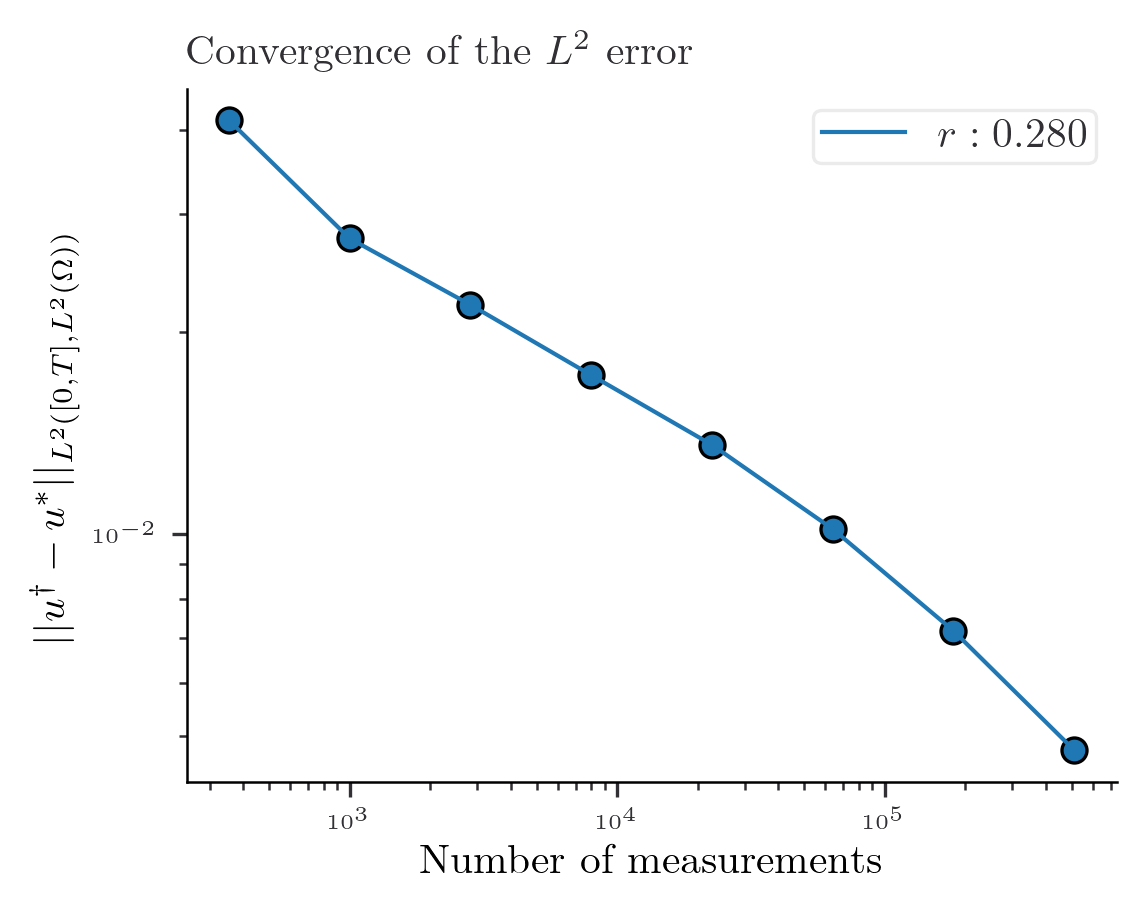

In [723]:
fig = plt.figure(figsize=(width, height))
plt.plot(meas_list, error, label = r"$r :{:.03f}$".format(r))
plt.scatter(meas_list, error)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2([0, T], L^2(\Omega))}$")
plt.title(r"Convergence of the $L^2$ error")
plt.legend()

plt.show()
